In [1]:
# Import useful libraries
import pandas as pd, sys, pickle, ipywidgets, seaborn as sns
from sklearn.metrics import confusion_matrix
sys.path.append('../3-ml-models')
import utils

# **Generalization**

The project aim is to create a Machine Learning model capable of detecting the dates when a crop field has been manured, using satellite data. <br>
Now is the turn to see how much the *best model*, obtained in the [ML models notebook](https://github.com/Amatofrancesco99/master-thesis/blob/main/Notebooks/3-ml-models/notebook.ipynb), can generalize our classification problem. More precisely, the purpose is to see how it performs in detecting when crop fields have been manured in a different country from the trained one.

**N.B:** Since using radar indexes is useless (as seen), they won't be considered in this notebook.

In [2]:
s2_df = pd.read_csv('../../Datasets/other/other-fields-s2-features-extracted.gz', compression='gzip')

## **Modify original DataFrame**

The purpose of building this `DataFrame` and modifying the original one is to ensure that it is structured in the same manner as the one used to train the model.

By doing so, it can be ensured that the data is consistent and that the model can make predictions. This will help to check whether the research objectives have been achieved and ensure that the model is optimized for the classification task at hand.

In [3]:
# Sentinel-2
s2_df_mod = utils.get_modified_df(s2_df, sentinel=2)
s2_df_mod

,crop_field_name,consequent_s2_acquisitions,B1,B2,B3,B4,B5,B6,B7,B8,...,CARI2,MCARI,MCARI1,MCARI2,BSI,GLI,ALTERATION,SDI,manure_dates,y
0,P-PVPR,"[2022-01-06, 2022-01-11]",687.810860,676.196793,381.072886,298.325802,11.222668,367.789723,483.986152,578.134475,...,399.462340,483.668123,1133.017347,0.203651,34.159906,0.106621,0.303743,526.808673,['2022-03-31'],0.0
1,P-PVPR,"[2022-01-11, 2022-01-16]",261.150510,330.489431,214.768586,182.770044,147.293003,72.776603,78.505102,18.978863,...,669.220964,117.772302,185.941574,0.052732,929.032119,0.062612,0.094897,328.088557,['2022-03-31'],0.0
2,P-PVPR,"[2022-01-16, 2022-01-31]",5771.107507,5180.021137,4761.511297,4624.255102,4369.051020,3827.163994,3641.225948,3586.435496,...,11036.881242,394.195026,1280.340569,0.451321,16567.592337,0.056195,0.323921,383.844023,['2022-03-31'],0.0
3,P-PVPR,"[2022-01-31, 2022-02-20]",3302.066327,2910.313411,2534.679665,2389.765306,2258.928571,1998.626822,1916.246356,1900.370262,...,6168.708603,83.587040,478.662464,0.057273,8456.930442,0.005238,0.001145,800.884840,['2022-03-31'],0.0
4,P-PVPR,"[2022-02-20, 2022-02-25]",7861.017493,6927.431851,6130.450437,5886.305758,5448.576895,4412.897230,4103.556122,4059.272595,...,286.831577,423.258445,2250.062055,0.390796,19894.776295,0.036314,0.085591,1202.978863,['2022-03-31'],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,P-VAPR2,"[2022-11-20, 2022-11-25]",120.413483,171.456180,97.725843,97.532584,90.388764,50.752809,22.871910,114.833708,...,310.016522,25.751388,305.505978,0.032809,327.932683,0.020257,0.003821,242.179775,['2022-02-24'],0.0
136,P-VAPR2,"[2022-11-25, 2022-11-27]",2182.548315,1798.456180,1738.838202,1880.164045,1811.215730,1101.968539,900.321348,874.256180,...,8085.240306,213.366634,1668.975640,0.354067,6308.994070,0.048263,0.403094,1592.712360,['2022-02-24'],0.0
137,P-VAPR2,"[2022-11-27, 2022-12-07]",2235.002247,1918.566292,1792.642697,1874.588764,1767.062921,1254.134831,1118.862921,1052.071910,...,7626.600529,253.122779,1312.260135,0.320294,6738.953440,0.052033,0.359573,1456.548315,['2022-02-24'],0.0
138,P-VAPR2,"[2022-12-07, 2022-12-17]",24.741573,5.382022,24.435955,24.653933,60.869663,215.595506,247.285393,172.804494,...,60.123112,140.540057,360.920360,0.039155,157.826992,0.015101,0.004364,167.593258,['2022-02-24'],0.0


## **Test the best obtained model, on new unseen data**

The primary objective is to conduct a comprehensive test to evaluate the generalization capability of the best obtained model, specifically for crops located in Italy. 

This will help to determine the model's ability to generalize and adapt to different crops and environmental conditions, which is a crucial step in this research as it will enable to identify potential shortcomings.

### Load the model and the feature scaler

In the previous stage, the best model configuration was stored in memory.
Therefore, there is the need to retrieve the stored model and scaler (**if used**), to ensure that the indexes are transformed correctly and the model can make accurate predictions. 

This is an important step, as it will enable us to reuse the best model configuration and avoid the need to retrain the model from scratch, saving us time and resources.

In [4]:
model = pickle.load(open('../3-ml-models/saved-config/model.pkl', 'rb'))
scaler = pickle.load(open('../3-ml-models/saved-config/scaler.pkl', 'rb'))

### Select the useful indexes, and the column to be predicted

**N.B:** The selected features are the same as the ones used by the best model.

In [5]:
X = s2_df_mod[['EOMI3', 'SCI', 'EOMI1', 'SDI']]
y = s2_df_mod.iloc[:, -1]

### Show performances

A confusion matrix is a comprehensive way to gain more insight about a [classifier's performance](https://www.v7labs.com/blog/confusion-matrix-guide). <br>
In this case, since our classes are just two, the confusion matrix is binary. A binary confusion matrix is a specific table layout that allows the visualization of the performance of a binary classification algorithm, which is a supervised learning algorithm that classifies the data into two classes. 

It is a $[2,2]$ matrix that summarizes the performance of the algorithm by counting the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The four outcomes can be formulated in a $[2,2]$ confusion matrix, where the rows represent the actual class and the columns represent the predicted class. 

The displacement of TP, TN, FN and FP in the later on printed binary confusion matrix ([sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) is the following one:
$$\begin{bmatrix}
TN & FP\\
FN & TP
\end{bmatrix}$$

The confusion matrix allows the calculation of accuracy, precision, recall, or F1-score. Furthermore, it can also be used to calculate the sensitivity, specificity, and positive and negative predictive values of the algorithm. All of them are useful metrics in order to evaluate the goodness of the considered model.

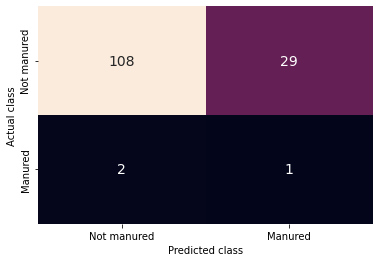

In [6]:
# Show confusion matrix
sns.heatmap(confusion_matrix(y, model.predict(scaler.transform(X) if scaler != None else X)),
           annot=True,
           fmt='d',
           cbar=False,
           xticklabels=['Not manured', 'Manured'], yticklabels=['Not manured', 'Manured'],
           annot_kws={
                'fontsize': 14
}).set(xlabel='Predicted class', ylabel='Actual class');